# Ames Housing Modeling

### Table of Contents

* [Step 1. Imports](#Step-1:--Imports) 
* [Step 2. Load the Data](#Step-2:--Load-the-Data)
* [Step 3.  Impute Values](#Step-3:-Impute-Values)
* [Step 4.  Create Dummy Variables](#Step-4:-Create-Dummy-Variables)
* [Step 5.  Addressing Multicollinearity](#Step-5:--Addressing-Multicollinearity)
    * [Highly Correlated Variables](#Highly-Correlated-Variables)
    * [Variance Inflation Factor](#Variance-Inflation-Factor)
* [Step 6.  Linear Regression Feature Coefficients](#Step-6:--Linear-Regression-Feature-Coefficients)
    * [Without Scaling](#Step-6-part-A:--Evaluate-Coefficients-WITHOUT-scaling)
    * [With Scaling](#Step-6-part-B:--Evaluate-Coefficients-WITH-scaling)
* [Step 7.  SHAP Feature Importance](#Step-7:--SHAP-Feature-Importance)
* [Step 8.  Train Test Split](#Step-8:-Train---Test-Split)
* [Step 9.  First Model: Random Forest](#Step-9:-First-Model:-Random-Forest)
    * [Random Forest - All Features](#Random-Forest-All-Features)
    * [Random Forest - Top-20 Features](#Random-Forest-Top-20-Features)
    * [Summary of Random Forest Model](#Summary-of-Random-Forest-Model)
* [Step 10.  Second Model: Ridge Regression](#Step-10:-Second-Model:-Ridge-Regression)
    * [Ridge Regression - All Features](#Ridge-Regression-with-All-Features)
    * [Ridge Regresion - Top-20 Features](#Ridge-Regression-Top-20-Variables)
    * [Summary of Ridge Regression Model](#Summary-of-Ridge-Regression-Model)
* [Step 11.  Third Model: Gradient Boosting](#Step-11:-Third-Model:-Gradient-Boosting)
    * [Gradient Boosting - All Features](#Gradient-Boosting-All-Features)
    * [Gradient BOosting - Top-20 Features](#Gradient-Boosting-Top-20-Features)
    * [Summary of Gradient Boosting Model](#Summary-of-Gradient-Boosting-Model)
* [Step 12.  Comparing the Models](#Step-12:--Comparing-Our-Models)
* [Step 13.  Test Case](#Step-13:--Use-a-model-to-predict-sales-price-on-a-test-case)
* [Step 14.  Summary](#Step-14:--Summary)
* [Step 15.  Next Steps](#Step-15:--Next-Steps)

# Step 1:  Imports

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime
from sklearn.ensemble import GradientBoostingRegressor
from math import sqrt
from tabulate import tabulate
import warnings
warnings.filterwarnings("ignore")

# Step 2:  Load the Data

In [2]:
housing_data = pd.read_csv('housing_data_cleaned.csv')

# Step 3: Impute Values

In [3]:
housing_data[['Lot Frontage', 'Mas Vnr Type', 'Mas Vnr Area', 'Electrical']].isnull().sum().sort_values(ascending = False)

Lot Frontage    490
Mas Vnr Type     23
Mas Vnr Area     23
Electrical        1
dtype: int64

In [4]:
fill_mean = ['Lot Frontage']

In [5]:
housing_data['Mas Vnr Type'].mode()

0    None
dtype: object

In [6]:
housing_data['Mas Vnr Area'].mode()

0    0.0
dtype: float64

In [7]:
housing_data['Electrical'].mode()

0    SBrkr
dtype: object

In [8]:
fill_mode = ['Mas Vnr Type', 'Mas Vnr Area', 'Electrical']

#### note.  I am not imputing values regarding things like basement, pool, garage, air conditioning etc which may not be present .  

In [9]:
for item in fill_mean:
    housing_data[item].fillna(housing_data[item].mean(), inplace = True)

In [10]:
for thing in fill_mode:
    housing_data[thing].fillna(housing_data[thing].mode(), inplace = True)

# Step 4: Create Dummy Variables

#### If you recall from our EDA, our data had quite a few 'object' variables.  Here we are going to create Dummy Variables so we can analyze both our numeric and our object variables

In [11]:
housing_data.head()
housing_data.shape

(2930, 78)

In [12]:
df = pd.get_dummies(housing_data, drop_first = True)
df = df.dropna()
df = df.drop(columns=['Order'])
df = df.drop(columns = ['Overall Qual'])
df.shape


(2747, 244)

# Step 5:  Addressing Multicollinearity

#### Highly Correlated Variables

In [13]:
###  These functions were adopted from an answer to a question on stack overflow
### We are looking at high correlations 
### with the idea that we can eliminate variables that have extremely high correlation with another variable

def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(df, 9))

Top Absolute Correlations
Sale Type_New         Sale Condition_Partial    0.985696
Exterior 1st_CemntBd  Exterior 2nd_CmentBd      0.980893
Exterior 1st_VinylSd  Exterior 2nd_VinylSd      0.978538
Exterior 1st_MetalSd  Exterior 2nd_MetalSd      0.972056
Roof Style_Gable      Roof Style_Hip            0.945156
Exter Qual_Gd         Exter Qual_TA             0.906449
Exter Cond_Gd         Exter Cond_TA             0.896934
Exterior 1st_HdBoard  Exterior 2nd_HdBoard      0.891455
Garage Qual_Fa        Garage Qual_TA            0.886101
dtype: float64


In [14]:
#  It looks like there is a high (> .95) correlation betweeen a few of our variables.
#  With that we are safe to drop the following variables:
#  Sale  Contidion_Partial, Exterior 2nd_CmentD, Exterior 2nd_VinlySd, and Exterior 2nd_MetalSd
# Lets go ahead and do that!

In [15]:
df = df.drop(columns=['Sale Condition_Partial', 'Exterior 2nd_CmentBd', 'Exterior 2nd_VinylSd', 'Exterior 2nd_MetalSd'])

In [16]:
print("Top Absolute Correlations")
print(get_top_abs_correlations(df, 9))

Top Absolute Correlations
Roof Style_Gable      Roof Style_Hip          0.945156
Exter Qual_Gd         Exter Qual_TA           0.906449
Exter Cond_Gd         Exter Cond_TA           0.896934
Exterior 1st_HdBoard  Exterior 2nd_HdBoard    0.891455
Garage Qual_Fa        Garage Qual_TA          0.886101
MS Zoning_FV          Neighborhood_Somerst    0.869312
Exterior 1st_Wd Sdng  Exterior 2nd_Wd Sdng    0.868191
Garage Cars           Garage Area             0.845252
Year Built            Garage Yr Blt           0.842375
dtype: float64


In [17]:
#  Now that we have addressed our high correlations, we can look at the multicolinearity in more detail using VIF. 

#### Variance Inflation Factor

In [18]:
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [19]:

features = df.drop(columns=['SalePrice'])

X = add_constant(features)
vif = pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns)
vif = vif.sort_values(ascending=False)
vif = vif.round(2)

print(vif.head(10))


BsmtFin SF 2              inf
Gr Liv Area               inf
Low Qual Fin SF           inf
2nd Flr SF                inf
1st Flr SF                inf
Total Bsmt SF             inf
Bsmt Unf SF               inf
BsmtFin SF 1              inf
const              2833808.89
MS Zoning_RL          1928.48
dtype: float64


#####  Ok I am going to take these VIF scores by groupings.  We see a handful of variables with a variety of square foot measurements.  Going back to our Feature Importance, one of our most important Features were Gr Liv Area ,BsmtFin SF 1, and Total Bsmt Sq Ft.  So we want to keep these variables and remove some other variables that are telling us the same information. 

In [20]:
df = df.drop(columns=['BsmtFin SF 2', 'Low Qual Fin SF', '2nd Flr SF', '1st Flr SF', 'Bsmt Unf SF'])

##### OK. Next lets tackle the zoning variables.  None of these variables were identified as particularly important in our feature importance so I am going to remove indiscriminantly.  

In [21]:
df = df.drop(columns=['MS Zoning_RL', 'MS Zoning_RM', 'MS Zoning_FV', 'MS Zoning_RH', 'MS Zoning_C (all)', 'MS Zoning_I (all)'])

#####  Next we will try to identify area where there are two or more variables basically saying the opposite of each other ie condition fair or good and eliminate one of these

In [22]:
df = df.drop(columns =['Garage Qual_TA', 'Garage Qual_Fa', 'Garage Cond_TA', 'Roof Style_Hip', 'Mas Vnr Type_None', 'Exter Cond_TA', 'Garage Type_Detchd',
'MS SubClass', 'Exter Cond_Gd', 'Exterior 1st_VinylSd', 'Bsmt Cond_TA', 'Exterior 1st_Wd Sdng', 'Garage Qual_Gd', 'Exterior 1st_Plywood'   ,
'Exterior 2nd_HdBoard', 'Functional_Typ', 'Mas Vnr Type_Stone', 'House Style_1Story', 'BsmtFin Type 2_Unf', 'Garage Cond_Gd',
'Neighborhood_Edwards', 'Exterior 2nd_Wd Sdng', 'Garage Type_BuiltIn', 'Exterior 1st_CBlock', 'Bsmt Qual_TA', 'Kitchen Qual_TA'])


In [23]:

features = df.drop(columns=['SalePrice'])

X = add_constant(features)
vif = pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns)
vif = vif.sort_values(ascending=False)
vif = vif.round(2)

print(vif.head(19))

const                 2735205.09
Exter Qual_TA              15.07
Year Built                 13.03
Exter Qual_Gd              11.73
Gr Liv Area                 9.19
Condition 2_Norm            8.55
Foundation_PConc            7.63
PID                         7.53
Neighborhood_NAmes          6.87
Foundation_CBlock           6.21
Pool Area                   6.00
Garage Yr Blt               5.63
Fireplaces                  5.43
Garage Cars                 5.19
Condition 1_Norm            5.19
Garage Area                 5.14
Total Bsmt SF               4.99
Sale Type_WD                4.96
TotRms AbvGrd               4.95
dtype: float64


##### This is interesting.  We got rid of the 'zoning' variables and it looks like that resulted in reduced multicolinearity with neighorhood variables
With this done, lets look at the remaining variables

In [24]:
df = df.drop(columns=['Exter Qual_Gd', 'Foundation_PConc', 'Garage Yr Blt', 'Year Remod/Add'])

In [25]:
features = df.drop(columns=['SalePrice'])

X = add_constant(features)
vif = pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns)
vif = vif.sort_values(ascending=False)
vif = vif.round(2)

print(vif.head())

const               2714183.67
Year Built                9.98
Gr Liv Area               9.18
Condition 2_Norm          8.54
PID                       7.52
dtype: float64


###### ok.  this is good we have eliminated enough variables to keep our VIF below 10 for each remaining variable and have kept our important variables as indicated in our feature importance.

In [26]:
df.shape

(2747, 199)

# Step 6:  Linear Regression Feature Coefficients


### Step 6 part A:  Evaluate Coefficients WITHOUT scaling 

In [27]:
# Import regression modules
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [28]:
 
y = df[['SalePrice']]
X = df.drop(columns=['SalePrice'])
results = sm.OLS(y, X).fit()

coefs = results.params
#coefs = abs(coefs)
coefs.sort_values(ascending=False).head(5)

Neighborhood_GrnHill    136051.193859
Condition 2_PosA         90250.131444
Electrical_Mix           70502.849164
Neighborhood_StoneBr     68781.758793
Neighborhood_NridgHt     57973.372031
dtype: float64

In [29]:
coefs.sort_values(ascending=False).tail(5)

Condition 2_PosN       -73622.193755
Mas Vnr Type_CBlock    -91966.406850
Pool QC_TA            -158684.213611
Pool QC_Fa            -188326.499476
Pool QC_Gd            -331994.124866
dtype: float64

In [30]:
#print(results.summary())

##### Ok here we see a list of features with the highest coefficients.  They are not scaled so some features may have outsized impact on our model compared to if they had been scaled.

In [31]:
df[df['Pool QC_Gd']>0]

,PID,Lot Frontage,Lot Area,Overall Cond,Year Built,Mas Vnr Area,BsmtFin SF 1,Total Bsmt SF,Gr Liv Area,Bsmt Full Bath,...,Sale Type_ConLI,Sale Type_ConLw,Sale Type_New,Sale Type_Oth,Sale Type_VWD,Sale Type_WD,Sale Condition_AdjLand,Sale Condition_Alloca,Sale Condition_Family,Sale Condition_Normal
1498,908154235,313.00000,63887,5,2008,796.0,5644.0,6110.0,5642,2.0,...,0,0,1,0,0,0,0,0,0,0
1566,914475020,76.00000,9880,6,1977,0.0,522.0,1096.0,1118,1.0,...,0,0,0,0,0,1,0,0,0,1
2498,532476050,100.00000,14330,4,1974,145.0,1023.0,1748.0,2646,1.0,...,0,0,0,0,0,1,0,0,0,1
2735,905426150,69.22459,19690,7,1966,0.0,0.0,697.0,2201,0.0,...,0,0,0,0,0,1,0,1,0,0


### Step 6 part B:  Evaluate Coefficients WITH scaling

In [32]:
scaler = RobustScaler()
scaler.fit(df)
df_scaled = scaler.transform(df)
scaled_features_df = pd.DataFrame(df_scaled, index=df.index, columns=df.columns)

In [33]:
#note I am not scaling the dependent variable
y = df[['SalePrice']]
X = scaled_features_df.drop(columns=['SalePrice'])
results = sm.OLS(y, X).fit()
#print(results.summary())
coefs = results.params
coefs = abs(coefs)


##### Ok.  Well this is fascinating.  We have scaled our data and extracted the coefficients from an ordinary least squares regression.  Given the data is standardized the coefficients should be a reflection of the relative impact of the feature on the sales price.  What is interesting is that we do NOT see the same features as important when we compare this list to the list of important variables generated from the Random Forest Feature Importance we did earlier. 

In [34]:
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:              SalePrice   R-squared (uncentered):                   0.974
Model:                            OLS   Adj. R-squared (uncentered):              0.972
Method:                 Least Squares   F-statistic:                              495.5
Date:                Thu, 21 Jul 2022   Prob (F-statistic):                        0.00
Time:                        12:00:11   Log-Likelihood:                         -32416.
No. Observations:                2747   AIC:                                  6.522e+04
Df Residuals:                    2552   BIC:                                  6.638e+04
Df Model:                         195                                                  
Covariance Type:            nonrobust                                                  
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------

In [35]:
y_pred = results.fittedvalues

Text(0.5, 1.0, 'Relationship between predicted and actual Price')

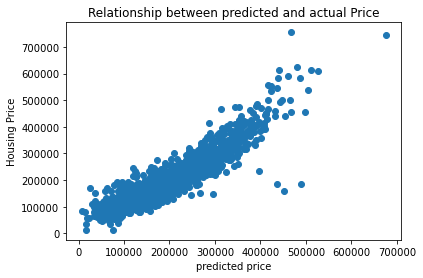

In [36]:
plt.scatter(y_pred, y)
plt.xlabel("predicted price")
plt.ylabel("Housing Price")
plt.title("Relationship between predicted and actual Price")

In [37]:
coefs = pd.DataFrame(coefs)

In [38]:
results.bse
std_err = pd.DataFrame(results.bse)

In [39]:
matrix = pd.concat([coefs, coefs, std_err], axis = 1)
matrix.columns = ['One', 'Coefs', 'BSE']
matrix.head(3)

,One,Coefs,BSE
PID,47193.985920,47193.985920,3087.197760
Lot Frontage,1162.696768,1162.696768,863.905472
Lot Area,1945.079333,1945.079333,501.949741


In [40]:
matrix = matrix.sort_values(by = 'Coefs', ascending = False)
matrix = matrix.head(20)

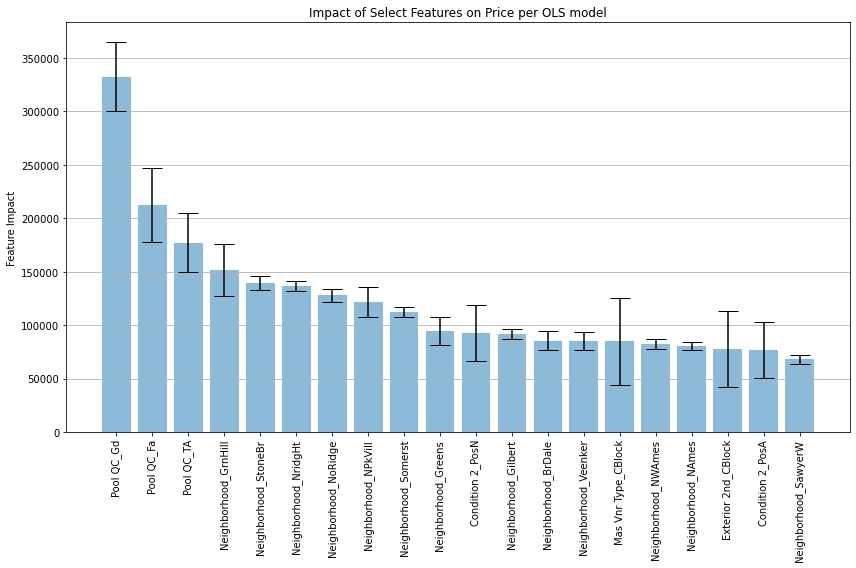

In [41]:
fig, ax = plt.subplots()
fig.set_figwidth(12)
fig.set_figheight(8)
ax.bar(matrix.index, matrix['Coefs'], yerr=matrix['BSE'], align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Feature Impact')
ax.set_title('Impact of Select Features on Price per OLS model')
ax.yaxis.grid(True)
ax.set_xticklabels(matrix.index, rotation = 90)
plt.tight_layout()
plt.savefig("OLS.Feature.Importance.png")

plt.show()

#### The above graph should represent the top 20 features in terms of their importance in predicting the Sales Price. These are not consistent with what we saw previously with the Random Forest Feature Importance.  Nor do they seem logically like the best variables.  I think we should look at a second method SHAP importance to see how that shakes out.

# Step 7:  SHAP Feature Importance

In [42]:
import shap
from xgboost.sklearn import XGBRegressor

In [43]:
model = XGBRegressor(n_estimators=1000, max_depth=10, learning_rate=0.001)
y = df[['SalePrice']]
X = scaled_features_df.drop(columns=['SalePrice'])
# Fit the Model
model.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.001, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

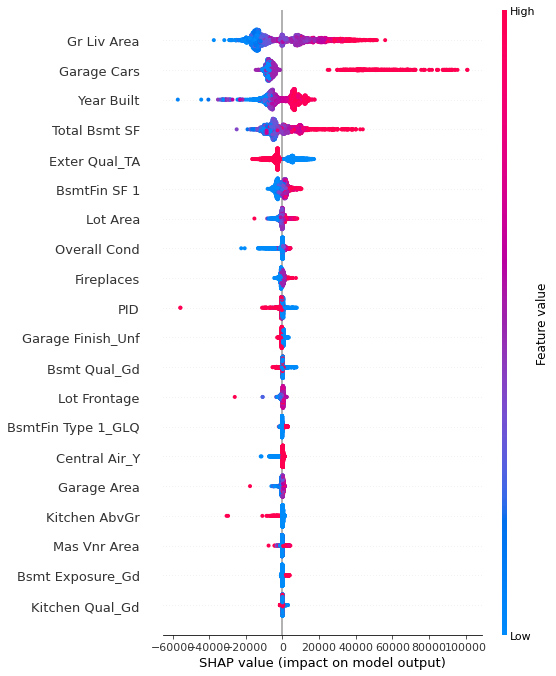

In [44]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, features=X, feature_names=X.columns, show = False)
f = plt.gcf()
plt.tight_layout()
plt.savefig("Shap.png")


#plt.show()

In [45]:
key_features = ['Gr Liv Area', 'Garage Cars', 'Year Built', 'Total Bsmt SF', 'Exter Qual_TA', 'BsmtFin SF 1', 'Lot Area', 'Overall Cond', 'PID', 'Fireplaces', 'Bsmt Qual_Gd', 'Garage Area', 'Garage Finish_Unf', 'Lot Frontage', 'Mas Vnr Area', 'Open Porch SF', 'Fireplace Qu_Gd', 'Wood Deck SF', 'Central Air_Y', 'Bsmt Exposure_Gd']


In [46]:
##### Note here:  These features seem more consistent with the Random Forest Feature Importance that we did earlier. 

# Step 8: Train - Test Split

In [47]:
df_y = df[['SalePrice']]
df_y.shape

(2747, 1)

In [48]:
df_X = scaled_features_df.drop(columns=['SalePrice'])
df_X.shape

(2747, 198)

In [49]:
X = df_X
y = df_y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=12)

#  Step 9: First Model: Random Forest

#### Random Forest All Features 

In [50]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)

RandomForestRegressor()

In [51]:
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

##### We can use RandomizedSearch to optimize the hyperparameters of max depth and number of n_estimators

In [52]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
n_est = [int(n) for n in np.logspace(start=2.9, stop=4, num=5)]
depth = [int(x) for x in np.linspace(10, 100, num = 10)]
param_grid = {'n_estimators': n_est, 'max_depth' : depth}
rf1 = RandomForestRegressor(random_state = 1519)
rf_cv = RandomizedSearchCV(rf1, param_grid, cv = 5, random_state = 123)
rf_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=1519),
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100],
                                        'n_estimators': [794, 1496, 2818, 5308,
                                                         10000]},
                   random_state=123)

In [53]:
print("Best Score:" + str(rf_cv.best_score_))
print("Best Parameters: " + str(rf_cv.best_params_))

Best Score:0.8718341166193955
Best Parameters: {'n_estimators': 5308, 'max_depth': 20}


##### The random search suggested the best hyperparameter is n_estimator of 5308  and max depth of 20.  Therefore I will try with n_estimators equal to 5308 and set max_depth equal to 20 and see what happens.

In [54]:
rf = RandomForestRegressor(n_estimators=5308, max_depth = 20)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=5308)

In [55]:
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

In [56]:
r2_score_train_rf = r2_score(y_train, y_train_pred)
r2_score_test_rf = r2_score(y_test, y_test_pred)
r2_score_train_rf, r2_score_test_rf

(0.9831738140614595, 0.8617960144308707)

In [57]:
MAE_train_rf = mean_absolute_error(y_train, y_train_pred)
MAE_test_rf = mean_absolute_error(y_test, y_test_pred)
MAE_train_rf, MAE_test_rf

(6180.414219386824, 17881.20919387838)

In [58]:
from math import sqrt
rmse_train_rf = sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test_rf = sqrt(mean_squared_error(y_test, y_test_pred))
rmse_train_rf, rmse_test_rf

(10277.478841742668, 29823.01047996797)

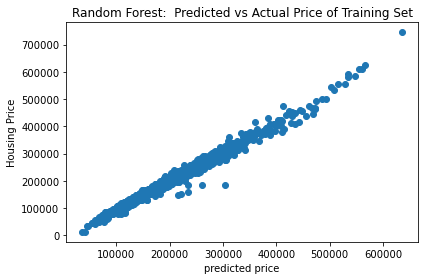

In [59]:
plt.scatter(y_train_pred, y_train)
plt.xlabel("predicted price")
plt.ylabel("Housing Price")
plt.title("Random Forest:  Predicted vs Actual Price of Training Set")
plt.tight_layout()
plt.savefig('Random.Forest.Actual.vs.Predicted.png')

In [60]:
# lets just summarize our findings from Random Forest model
from tabulate import tabulate
d = [ ["r2 Score Train", round(r2_score_train_rf, 3)], ["r2 Score Test", round(r2_score_test_rf, 3)], ["Mean Absolute Error (MAE) Train", MAE_train_rf],
    ["Mean Absolute Error(MAE) Test", MAE_test_rf], ["Root Mean Square Error (RMSE) Train", rmse_train_rf], ["Root Mean Square Error (RMSE) Test", rmse_test_rf]]

print(tabulate(d, headers=["Random Forest Evaluation Metrics", "Metric"]))

Random Forest Evaluation Metrics        Metric
-----------------------------------  ---------
r2 Score Train                           0.983
r2 Score Test                            0.862
Mean Absolute Error (MAE) Train       6180.41
Mean Absolute Error(MAE) Test        17881.2
Root Mean Square Error (RMSE) Train  10277.5
Root Mean Square Error (RMSE) Test   29823


#### Random Forest Top-20 Features

In [61]:
df_y = df[['SalePrice']]
df_X = scaled_features_df[key_features]

In [62]:
X_train_prime, X_test_prime, y_train_prime, y_test_prime = train_test_split(df_X, df_y, test_size=0.25, random_state=12)

In [63]:
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train_prime, y_train_prime)

RandomForestRegressor()

In [64]:
y_train_pred_prime = rf.predict(X_train_prime)
y_test_pred_prime = rf.predict(X_test_prime)

#### Once more we can use randomized search to optimize the hyperparameters of n_estimators and max_depth.

In [65]:

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
n_est = [int(n) for n in np.logspace(start=3.8, stop=4.2, num=5)]
depth = [int(x) for x in np.linspace(10, 120, num = 12)]
param_grid = {'n_estimators': n_est, 'max_depth' : depth}
rf1 = RandomForestRegressor(random_state = 1519)
rf_cv = RandomizedSearchCV(rf1, param_grid, cv = 5, random_state = 123)
rf_cv.fit(X_train_prime, y_train_prime)


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=1519),
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      120],
                                        'n_estimators': [6309, 7943, 10000,
                                                         12589, 15848]},
                   random_state=123)

In [66]:
print("Best Score:" + str(rf_cv.best_score_))
print("Best Parameters: " + str(rf_cv.best_params_))

Best Score:0.8687077704370665
Best Parameters: {'n_estimators': 10000, 'max_depth': 110}


#### The cross validation suggests using a max depth of 110 and n_estimators of 10,000  We will now run the model with these hyperpameters.

In [67]:
rf = RandomForestRegressor(n_estimators=10000, max_depth = 110)
rf.fit(X_train_prime, y_train_prime)

RandomForestRegressor(max_depth=110, n_estimators=10000)

In [68]:
r2_score_train_prime_rf = r2_score(y_train_prime, y_train_pred_prime)
r2_score_test_prime_rf = r2_score(y_test_prime, y_test_pred_prime)
r2_score_train_prime_rf, r2_score_test_prime_rf

(0.9825895920820065, 0.8626290369291645)

In [69]:
MAE_train_prime_rf = mean_absolute_error(y_train_prime, y_train_pred_prime)
MAE_test_prime_rf = mean_absolute_error(y_test_prime, y_test_pred_prime)
MAE_train_prime_rf, MAE_test_prime_rf

(6329.584337494221, 18017.256470506687)

In [70]:
rmse_train_prime_rf = sqrt(mean_squared_error(y_train_prime, y_train_pred_prime))
rmse_test_prime_rf = sqrt(mean_squared_error(y_test_prime, y_test_pred_prime))
rmse_train_prime_rf, rmse_test_prime_rf

(10454.37857477369, 29732.995754971063)

#### Summary of Random Forest Model

In [71]:
# lets just summarize our findings from Random Forest model
from tabulate import tabulate
d = [ ["r2 Score Train", round(r2_score_train_rf, 3), round(r2_score_train_prime_rf, 3)], ["r2 Score Test", round(r2_score_test_rf, 3), round(r2_score_test_prime_rf, 3)], ["Mean Absolute Error (MAE) Train", round(MAE_train_rf, 2), round(MAE_train_prime_rf, 2)],
    ["Mean Absolute Error(MAE) Test", round(MAE_test_rf, 2), round(MAE_test_prime_rf, 2)], ["Root Mean Square Error (RMSE) Train", round(rmse_train_rf, 2), round(rmse_train_prime_rf, 2)], ["Root Mean Square Error (RMSE) Test", round(rmse_test_rf, 2), round(rmse_test_prime_rf, 2)] , ["Optimal n_estimtor", "5308", "10000"], ["Optimal max_depth", "20", "110"]]

print(tabulate(d, headers=["Random Forest Evaluation Metrics", "Model: All Features", "Model:  Top Twenty Features"]))

Random Forest Evaluation Metrics       Model: All Features    Model:  Top Twenty Features
-----------------------------------  ---------------------  -----------------------------
r2 Score Train                                       0.983                          0.983
r2 Score Test                                        0.862                          0.863
Mean Absolute Error (MAE) Train                   6180.41                        6329.58
Mean Absolute Error(MAE) Test                    17881.2                        18017.3
Root Mean Square Error (RMSE) Train              10277.5                        10454.4
Root Mean Square Error (RMSE) Test               29823                          29733
Optimal n_estimtor                                5308                          10000
Optimal max_depth                                   20                            110


# Step 10: Second Model: Ridge Regression

##### Ridge Regression with All Features

In [72]:
from sklearn.linear_model import Ridge

In [73]:
ridge = Ridge(alpha = 1)
ridge.fit(X_train, y_train)

Ridge(alpha=1)

In [74]:
y_train_pred = ridge.predict(X_train)
y_test_pred = ridge.predict(X_test)

##### Tuning our hyperparameters.

In [75]:
n_est = [int(n) for n in np.logspace(start=0, stop=3, num=30)]
param_grid = {'alpha':n_est}
ridge = Ridge()
ridge_cv= GridSearchCV(ridge,param_grid,cv=5)
ridge_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [1, 1, 1, 2, 2, 3, 4, 5, 6, 8, 10, 13, 17, 22,
                                   28, 35, 45, 57, 72, 92, 117, 148, 188, 239,
                                   303, 385, 489, 621, 788, 1000]})

In [76]:
print("Best Score:" + str(ridge_cv.best_score_))
print("Best Parameters: " + str(ridge_cv.best_params_))

Best Score:0.7954374447135271
Best Parameters: {'alpha': 6}


#####  Ok our grid search indicated a much higher alpha so lets revisit with this higher alpha

In [77]:
ridge = Ridge(alpha = 6)
ridge.fit(X_train, y_train)

Ridge(alpha=6)

In [78]:
y_train_pred = ridge.predict(X_train)
y_test_pred = ridge.predict(X_test)

In [79]:
r2_score_train_ridge = r2_score(y_train, y_train_pred)
r2_score_test_ridge = r2_score(y_test, y_test_pred)
r2_score_train_ridge, r2_score_test_ridge 

(0.8798255906175709, 0.8829770584813794)

In [80]:
MAE_train_ridge = mean_absolute_error(y_train, y_train_pred)
MAE_test_ridge = mean_absolute_error(y_test, y_test_pred)
MAE_train_ridge, MAE_test_ridge

(17309.22082550729, 18166.598099278013)

In [81]:
rmse_train_ridge = sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test_ridge = sqrt(mean_squared_error(y_test, y_test_pred))
rmse_train_ridge, rmse_test_ridge

(27466.27396581779, 27442.691443979973)

Text(0.5, 1.0, 'Relationship between predicted and actual Price of Training Set')

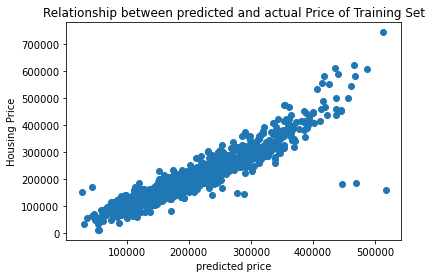

In [82]:
plt.scatter(y_train_pred, y_train)
plt.xlabel("predicted price")
plt.ylabel("Housing Price")
plt.title("Relationship between predicted and actual Price of Training Set")

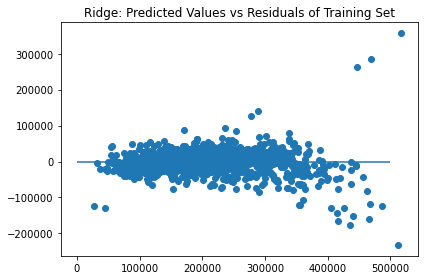

In [83]:
plt.scatter(y_train_pred, (y_train_pred - y_train))
plt.hlines(y=0, xmin = 0, xmax = 500000)
plt.title("Ridge: Predicted Values vs Residuals of Training Set")
plt.tight_layout()
plt.savefig('Rigde.Residuals.png')

Text(0.5, 1.0, 'Predicted Values vs Residuals of Training Set')

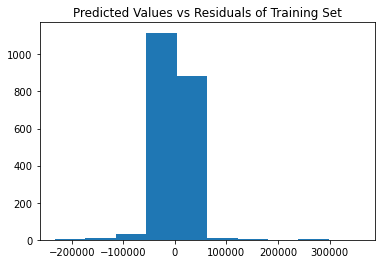

In [84]:
plt.hist(y_train_pred - y_train, bins = 10)
plt.title("Predicted Values vs Residuals of Training Set")

In [85]:
# lets just summarize our findings from Ridge Regression 
from tabulate import tabulate
d = [ ["r2 Score Train", round(r2_score_train_ridge, 3)], ["r2 Score Test", round(r2_score_test_ridge, 3)], ["Mean Absolute Error (MAE) Train", MAE_train_ridge],
    ["Mean Absolute Error(MAE) Test", MAE_test_ridge], ["Root Mean Square Error (RMSE) Train", rmse_train_ridge], ["Root Mean Square Error (RMSE) Test", rmse_test_ridge]]

print(tabulate(d, headers=["Ridge Regression Evaluation Metrics", "Metric"]))

Ridge Regression Evaluation Metrics       Metric
-------------------------------------  ---------
r2 Score Train                             0.88
r2 Score Test                              0.883
Mean Absolute Error (MAE) Train        17309.2
Mean Absolute Error(MAE) Test          18166.6
Root Mean Square Error (RMSE) Train    27466.3
Root Mean Square Error (RMSE) Test     27442.7


#### Ridge Regression Top-20 Variables

In [86]:
df_y = df[['SalePrice']]
df_X = scaled_features_df[key_features]

In [87]:
X_train_prime, X_test_prime, y_train_prime, y_test_prime = train_test_split(df_X, df_y, test_size=0.25, random_state=12)

In [88]:
ridge = Ridge(alpha = 1)
ridge.fit(X_train_prime, y_train_prime)

Ridge(alpha=1)

In [89]:
y_train_pred_prime = ridge.predict(X_train_prime)
y_test_pred_prime = ridge.predict(X_test_prime)

#### Once again we can tune the hyperparameter of Alpha for ths feature set.

In [90]:
n_est = [int(n) for n in np.logspace(start=0, stop=3, num=30)]
param_grid = {'alpha':n_est}
ridge = Ridge()
ridge_cv= GridSearchCV(ridge,param_grid,cv=5)
ridge_cv.fit(X_train_prime, y_train_prime)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [1, 1, 1, 2, 2, 3, 4, 5, 6, 8, 10, 13, 17, 22,
                                   28, 35, 45, 57, 72, 92, 117, 148, 188, 239,
                                   303, 385, 489, 621, 788, 1000]})

In [91]:
print("Best Score:" + str(ridge_cv.best_score_))
print("Best Parameters: " + str(ridge_cv.best_params_))

Best Score:0.7527080835319497
Best Parameters: {'alpha': 35}


#### The cross validation suggests running the model with an alpha of 35, so we will run the model with this hyperparameter and take note of our rSquared and RMSE.

In [92]:
ridge = Ridge(alpha = 35)
ridge.fit(X_train_prime, y_train_prime)

Ridge(alpha=35)

In [93]:
y_train_pred_prime = ridge.predict(X_train_prime)
y_test_pred_prime = ridge.predict(X_test_prime)

In [94]:
r2_score_train_prime_ridge = r2_score(y_train_prime, y_train_pred_prime)
r2_score_test_prime_ridge = r2_score(y_test_prime, y_test_pred_prime)
r2_score_train_prime_ridge, r2_score_test_prime_ridge 

(0.7887600819497019, 0.8290185447274234)

In [95]:
MAE_train_prime_ridge = mean_absolute_error(y_train_prime, y_train_pred_prime)
MAE_test_prime_ridge = mean_absolute_error(y_test_prime, y_test_pred_prime)
MAE_train_prime_ridge, MAE_test_prime_ridge

(22532.014670635854, 22350.097178278542)

In [96]:
rmse_train_prime_ridge = sqrt(mean_squared_error(y_train_prime, y_train_pred_prime))
rmse_test_prime_ridge = sqrt(mean_squared_error(y_test_prime, y_test_pred_prime))
rmse_train_prime_ridge, rmse_test_prime_ridge

(36415.11993298389, 33171.545170133235)

#### Summary of Ridge Regression Model

In [97]:
# lets just summarize our findings from Ridge Regression 
from tabulate import tabulate
d = [ ["r2 Score Train", round(r2_score_train_ridge, 3), round(r2_score_train_prime_ridge, 3)], ["r2 Score Test", round(r2_score_test_ridge, 3), round(r2_score_test_prime_ridge, 3)], ["Mean Absolute Error (MAE) Train", MAE_train_ridge, MAE_train_prime_ridge],
    ["Mean Absolute Error(MAE) Test", MAE_test_ridge, MAE_test_prime_ridge], ["Root Mean Square Error (RMSE) Train", rmse_train_ridge, rmse_train_prime_ridge], ["Root Mean Square Error (RMSE) Test", rmse_test_ridge, rmse_test_prime_ridge], ["Optimal Alpha", "6", "35"]]

print(tabulate(d, headers=["Ridge Regression Evaluation Metrics", "Model: All Features", "Model:  Top Twenty Features"]))

Ridge Regression Evaluation Metrics      Model: All Features    Model:  Top Twenty Features
-------------------------------------  ---------------------  -----------------------------
r2 Score Train                                         0.88                           0.789
r2 Score Test                                          0.883                          0.829
Mean Absolute Error (MAE) Train                    17309.2                        22532
Mean Absolute Error(MAE) Test                      18166.6                        22350.1
Root Mean Square Error (RMSE) Train                27466.3                        36415.1
Root Mean Square Error (RMSE) Test                 27442.7                        33171.5
Optimal Alpha                                          6                             35


# Step 11: Third Model: Gradient Boosting

#### Gradient Boosting All Features

In [98]:
gb = GradientBoostingRegressor()
gb.fit(X_train, y_train)

GradientBoostingRegressor()

In [99]:
y_train_pred = gb.predict(X_train)
y_test_pred = gb.predict(X_test)

#### Once again we can try to optimize our hyperparameters.  This time the learning rate and the max depth.

In [100]:
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
#depth = [int(x) for x in np.linspace(1, 1261, num = 20)]
depth = [1, 2, 3, 4, 5, 6, 7,  9, 22, 39, 57, 101, 125, 255, 427, 601, 885, 1021]
param_grid = {'learning_rate':learning_rates, 'max_depth': depth}
gb = GradientBoostingRegressor()
gb_cv= GridSearchCV(gb,param_grid,cv=5)
gb_cv.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(),
             param_grid={'learning_rate': [0.05, 0.1, 0.25, 0.5, 0.75, 1],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 9, 22, 39, 57, 101,
                                       125, 255, 427, 601, 885, 1021]})

In [101]:
print("Best Score:" + str(gb_cv.best_score_))
print("Best Parameters: " + str(gb_cv.best_params_))

Best Score:0.8932704567279888
Best Parameters: {'learning_rate': 0.1, 'max_depth': 4}


In [102]:
gb = GradientBoostingRegressor(learning_rate = 0.1, max_depth = 4)
gb.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=4)

In [103]:
y_train_pred = gb.predict(X_train)
y_test_pred = gb.predict(X_test)

In [104]:
r2_score_train_gb = r2_score(y_train, y_train_pred)
r2_score_test_gb = r2_score(y_test, y_test_pred)
r2_score_train_gb, r2_score_test_gb

(0.9736176226599326, 0.88906108160642)

In [105]:
MAE_train_gb = mean_absolute_error(y_train, y_train_pred)
MAE_test_gb = mean_absolute_error(y_test, y_test_pred)
MAE_train_gb, MAE_test_gb

(9603.461581607622, 16993.971910555865)

In [106]:
rmse_train_gb = sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test_gb = sqrt(mean_squared_error(y_test, y_test_pred))
rmse_train_gb, rmse_test_gb

(12869.175197724757, 26719.797414007746)

Text(0.5, 1.0, 'Relationship between predicted and actual Price of Training Set')

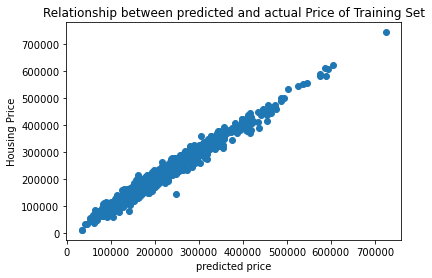

In [107]:
plt.scatter(y_train_pred, y_train)
plt.xlabel("predicted price")
plt.ylabel("Housing Price")
plt.title("Relationship between predicted and actual Price of Training Set")

In [108]:
# lets summarize our data for gradient boosting with All Features
d = [ ["r2 Score Train", round(r2_score_train_gb, 3)], ["r2 Score Test", round(r2_score_test_gb, 3)], ["Mean Absolute Error (MAE) Train", MAE_train_gb],
    ["Mean Absolute Error(MAE) Test", MAE_test_gb], ["Root Mean Square Error (RMSE) Train", rmse_train_gb], ["Root Mean Square Error (RMSE) Test", rmse_test_gb]]

print(tabulate(d, headers=["Gradient Boosting Evaluation Metrics", "Metric"]))

Gradient Boosting Evaluation Metrics       Metric
--------------------------------------  ---------
r2 Score Train                              0.974
r2 Score Test                               0.889
Mean Absolute Error (MAE) Train          9603.46
Mean Absolute Error(MAE) Test           16994
Root Mean Square Error (RMSE) Train     12869.2
Root Mean Square Error (RMSE) Test      26719.8


#### Gradient Boosting Top-20 Features

In [109]:
gb = GradientBoostingRegressor()
gb.fit(X_train_prime, y_train_prime)

GradientBoostingRegressor()

In [110]:
y_train_pred_prime = gb.predict(X_train_prime)
y_test_pred_prime = gb.predict(X_test_prime)

#### Again we will optimize the hyperparameters of learning_rates and max_depth and run the model with these hyperparameters taking note of the r-squared and RMSE.

In [111]:
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
#depth = [int(x) for x in np.linspace(1, 1261, num = 20)]
depth = [1, 2, 3, 4, 5, 6, 7,  9, 22, 39, 57, 101, 125, 255, 427, 601, 885, 1021]
param_grid = {'learning_rate':learning_rates, 'max_depth':depth}
gb = GradientBoostingRegressor()
gb_cv= GridSearchCV(gb,param_grid,cv=5)
gb_cv.fit(X_train_prime, y_train_prime)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(),
             param_grid={'learning_rate': [0.05, 0.1, 0.25, 0.5, 0.75, 1],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 9, 22, 39, 57, 101,
                                       125, 255, 427, 601, 885, 1021]})

In [112]:
print("Best Score:" + str(gb_cv.best_score_))
print("Best Parameters: " + str(gb_cv.best_params_))

Best Score:0.8894840942414524
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5}


In [113]:
gb = GradientBoostingRegressor(learning_rate = .1, max_depth = 5)
gb.fit(X_train_prime, y_train_prime)

GradientBoostingRegressor(max_depth=5)

In [114]:
y_train_pred_prime = gb.predict(X_train_prime)
y_test_pred_prime = gb.predict(X_test_prime)

In [115]:
r2_score_train_prime_gb = r2_score(y_train_prime, y_train_pred_prime)
r2_score_test_prime_gb = r2_score(y_test_prime, y_test_pred_prime)
r2_score_train_prime_gb, r2_score_test_prime_gb

(0.9834198939341587, 0.8858302222506819)

In [116]:
MAE_train_prime_gb = mean_absolute_error(y_train_prime, y_train_pred_prime)
MAE_test_prime_gb = mean_absolute_error(y_test_prime, y_test_pred_prime)
MAE_train_prime_gb, MAE_test_prime_gb

(7756.688893430771, 17109.886894416068)

In [117]:
rmse_train_prime_gb = sqrt(mean_squared_error(y_train_prime, y_train_pred_prime))
rmse_test_prime_gb = sqrt(mean_squared_error(y_test_prime, y_test_pred_prime))
rmse_train_prime_gb, rmse_test_prime_gb

(10202.048920479267, 27106.083708659753)

#### Summary of Gradient Boosting Model 

In [118]:
# lets summarize our data for gradient boosting
d = [ ["r2 Score Train", round(r2_score_train_gb, 3), round(r2_score_train_prime_gb, 3)], ["r2 Score Test", round(r2_score_test_gb, 3), round(r2_score_test_prime_gb, 3)], ["Mean Absolute Error (MAE) Train", MAE_train_gb, MAE_train_prime_gb],
    ["Mean Absolute Error(MAE) Test", MAE_test_gb, MAE_test_prime_gb], ["Root Mean Square Error (RMSE) Train", rmse_train_gb, rmse_train_prime_gb], ["Root Mean Square Error (RMSE) Test", rmse_test_gb, rmse_test_prime_gb], ["Optimal Learning Rate", "0.1", "0.1"], ["Optimal Max Depth", "4", "5"]]

print(tabulate(d, headers=["Gradient Boosting Evaluation Metrics", "Model: All Features", "Model: Top Twenty Features"]))

Gradient Boosting Evaluation Metrics      Model: All Features    Model: Top Twenty Features
--------------------------------------  ---------------------  ----------------------------
r2 Score Train                                          0.974                         0.983
r2 Score Test                                           0.889                         0.886
Mean Absolute Error (MAE) Train                      9603.46                       7756.69
Mean Absolute Error(MAE) Test                       16994                         17109.9
Root Mean Square Error (RMSE) Train                 12869.2                       10202
Root Mean Square Error (RMSE) Test                  26719.8                       27106.1
Optimal Learning Rate                                   0.1                           0.1
Optimal Max Depth                                       4                             5


# Step 12:  Comparing Our Models

In this notebook I have used four different regression algorithms to model the Ames, Iowa housing data with the objective of finding the best model to predect a dependent variable (Sales Price) based on the features of the property.  

For each model, I used a grid (or random search) search cross-validation to optimize the hyperparameters.  For our normal Linear Regression Model, no hyperparameter optimization was available, so I reduced the number of variables to just our top twenty variables as identified by our SHAP feature importance.  

The table below outlines which hyperparameters were optimized for each model as well as the optimal hyperparameters as indicated by our grid search.



In [119]:
#import io
d = [ ["Random Forest (All Features)",round(r2_score_test_rf, 3), round(rmse_test_rf, 2), "n_estimators = 5,308", 'max_depth = 20'], ["", "", "" ,""], ["Random Forest (Top 20 Features)",round(r2_score_test_prime_rf, 3), round(rmse_test_prime_rf, 2), "n_estimators = 10,000", 'max_depth = 110'], ["", "", "" ,""], ["Ridge Regression (All Features)", round(r2_score_test_ridge, 3), round(rmse_test_ridge, 2), "Alpha = 6"], ["", "", "", ""] ,["Ridge Regression (Top 20 Features)", round(r2_score_test_prime_ridge, 3), round(rmse_test_prime_ridge, 2), "Alpha = 35"], ["", "", "", ""] ,
    ["Gradient Boosting (All Features)",round(r2_score_test_gb, 3), round(rmse_test_gb, 2), "Learning Rate = 0.1", "max_depth = 4"],  ["", "", "", ""], ["Gradient Boosting (Top 20 Features)",round(r2_score_test_prime_gb, 3), round(rmse_test_prime_gb, 2), "Learning Rate = 0.1", "max_depth = 5"] ]
print(" ")
print(" ")

datalist2 = tabulate(d, headers=["   Model  ", "r2 Score \n (Test-Data)", "Root Mean Square Error \n (Test Data)", "Hyperparameter 1", "Hyperparameter 2"])
print(datalist2)

#with io.open("kaita.txt", "w", encoding="utf-8") as outf:
#    outf.write(datalist2)

print("")

 
 
   Model                             r2 Score        Root Mean Square Error     Hyperparameter 1       Hyperparameter 2
                                      (Test-Data)     (Test Data)
-----------------------------------  --------------  -------------------------  ---------------------  ------------------
Random Forest (All Features)         0.862           29823.01                   n_estimators = 5,308   max_depth = 20
Random Forest (Top 20 Features)      0.863           29733.0                    n_estimators = 10,000  max_depth = 110
Ridge Regression (All Features)      0.883           27442.69                   Alpha = 6
Ridge Regression (Top 20 Features)   0.829           33171.55                   Alpha = 35
Gradient Boosting (All Features)     0.889           26719.8                    Learning Rate = 0.1    max_depth = 4
Gradient Boosting (Top 20 Features)  0.886           27106.08                   Learning Rate = 0.1    max_depth = 5



One metric we will examine is the R-squared which is the extent to which the variance in the independent variables influences the variance in our dependent variable.  This is referred to as the Goodness of Fit as it is an indication of how well the data fits the regression model.  So the higher R-squared will indicate a model that creates a better fit of our data.  
Of our models, the two decision tree models (Gradient Boosting and Random Forest) give us the best R-Squared on the training data, and all of the models perform similarly on the test data.

The other metric we might focus on is the Root Mean Square Error (RMSE) which is a measure of how far our predictions fall from our actual Sales Price.  The Root Mean Squared Error is in the same units as our Dependent Variable (USD) and is therfore a usefull measure.  It is our objective to minimize RMSE.  Here our decision tree based models perform better than our two other models.  


In [120]:
d = [ ["r2 Score Train",r2_score_train_rf, r2_score_train_ridge, r2_score_train_gb], ["r2 Score Test", r2_score_test_rf, r2_score_test_ridge, r2_score_test_gb], ["Mean Absolute Error (MAE) Train",MAE_train_rf, MAE_train_ridge, MAE_train_gb],
    ["Mean Absolute Error(MAE) Test",MAE_test_rf, MAE_test_ridge, MAE_test_gb], ["Root Mean Square Error (RMSE) Train",rmse_train_rf, rmse_train_ridge, rmse_train_gb], ["Root Mean Square Error (RMSE) Test",rmse_test_rf, rmse_test_ridge, rmse_test_gb]]
print("")
print(tabulate(d, headers=["   Evaluation Metric  ", "Random Forest", "Ridge Regression", "Linear Regression", "Gradient Boosting"]))


   Evaluation Metric                   Random Forest    Ridge Regression    Linear Regression
-----------------------------------  ---------------  ------------------  -------------------
r2 Score Train                              0.983174            0.879826             0.973618
r2 Score Test                               0.861796            0.882977             0.889061
Mean Absolute Error (MAE) Train          6180.41            17309.2               9603.46
Mean Absolute Error(MAE) Test           17881.2             18166.6              16994
Root Mean Square Error (RMSE) Train     10277.5             27466.3              12869.2
Root Mean Square Error (RMSE) Test      29823               27442.7              26719.8


Between the Random Forest and the Gradient Boosting Models, I prefer the Gradient Boosting model.  
This model does not perform as well as the Random Forest on the Training Set but performs better than the Random Forest both in the R-Squared and the RMSE when looking at the Test Data.  Based on this it is possible the Random Forest is overfitting to the training set.  

The purpose of our model is to determine the price of a real estate offering where the sales price is unknown.  
Given the superior performance on the training data I would expect the Gradinet Boosting Regressor to perform the best on a new data set.  

Therefore I would recommend using the Gradient Boosting Model on this dataset.  



In [121]:
d = [ ["Model", "Gradient Boosting (All Features) "], ["Hyperparameter 1", "Max Depth = 4"], ["Hyperparameter 2", "Learning Rate = 0.1"], ["r2 Score Train",round(r2_score_train_gb, 3)], ["r2 Score Test", round(r2_score_test_gb, 3)], 
     ["Root Mean Square Error (RMSE) Train", round(rmse_train_gb, 0)], ["Root Mean Square Error (RMSE) Test",round(rmse_test_gb, 0)]]
print("")
datalist2 = tabulate(d, headers=["   Selected Model ", "Gradient Boosting (All Features)"])
print(datalist2)


text_file=open("AmesModelMetrics.txt","w")
text_file.write(datalist2)
text_file.close()


   Selected Model                    Gradient Boosting (All Features)
-----------------------------------  ----------------------------------
Model                                Gradient Boosting (All Features)
Hyperparameter 1                     Max Depth = 4
Hyperparameter 2                     Learning Rate = 0.1
r2 Score Train                       0.974
r2 Score Test                        0.889
Root Mean Square Error (RMSE) Train  12869.0
Root Mean Square Error (RMSE) Test   26720.0


# Step 13:  Use a model to predict sales price on a test case 

In [122]:
gb = GradientBoostingRegressor(learning_rate = 0.1, max_depth = 4)
gb.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=4)

In [123]:
y_train_pred = gb.predict(X_train)
y_test_pred = gb.predict(X_test)

In [124]:
X_bm = X_test.iloc[25, :]

X_bm.shape

(198,)

In [125]:
X_train.shape

(2060, 198)

In [126]:
X_bm = X_bm.transpose
X_bm

<bound method IndexOpsMixin.transpose of PID                      -0.002638
Lot Frontage              0.567127
Lot Area                  0.012352
Overall Cond              1.000000
Year Built               -0.347826
                            ...   
Sale Type_WD              0.000000
Sale Condition_AdjLand    0.000000
Sale Condition_Alloca     0.000000
Sale Condition_Family     0.000000
Sale Condition_Normal     0.000000
Name: 611, Length: 198, dtype: float64>

In [127]:
bm_pred = gb.predict(X_test.iloc[26, :].array.reshape(1, -1))

In [128]:
bm_pred

array([247967.58551843])

In [129]:
y_test.iloc[26, :]

SalePrice    226000
Name: 1862, dtype: int64

#### Ok.  It looks like for this particular property, our model predicted a sales price of USD 247,968 when the actual sales price for this property was USD 226,000. 

# Step 14:  Summary

The goal of this project was to build a model that would use the features of recently sold homes to predict the sales price of a home in that same market. In the end, the tuned model was able to predict house price within an average error of ~$26k. This seems to be well within a range that could be useful though further conversations with potential stakeholders could shed light on how great of an issue this error would be.
Such stakeholders might include: :

    * Real Estate agents advising their clients
    
    * Investors valuing potential purchases
    
    * Mortgage Lenders conducting due diligence prior to lending etc
    
Although our data were limited to single family residential real estate transactions in Ames, Iowa, this type of analysis could be conducted for multifamily, condominium, or commercial real estate in any number of geographical locations.  


# Step 15:  Next Steps

A significant amount of time was spent optimizing the hyperparameters and each of our models included either one or two hyperparameters to tune.  However, it is likely that including additional parameters in a future analysis could result in a more robust model.  
Furthermore, while we assessed each model using two feature sets, additional feature sets i.e. top 50 variables may provide a more robust model. 
Finally, the data available is more than a decade old, so future analysis could include revisiting with more updated data or evaluating different types of real estate including condominiums, or commercial buildings.  
